In [1]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
import session_info
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import pickle

# Specific modules
import scanpy as sc
import anndata as an
from matplotlib.backends.backend_pdf import PdfPages

# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

# Import custom functions
from customPythonFunctions import generate_split_dir, composition_barplot, balanced_sample, generateID2SymbolDF


#plt.style.use(['science','nature','no-latex'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

overwriteFigures = True
overwriteData = True

**Load data**

In [2]:
adata = sc.read_h5ad(here("01_data_processing/results/05_INFLAMMATION_main_HVGsubset_scVI_UMAP_clinical_allGenes.h5ad"))
adata.uns['log1p']['base'] = None # only if logscale is computed
adata

AnnData object with n_obs × n_vars = 4918140 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable'
    uns: '_scvi

In [3]:
adata.obs.head()

,studyID,libraryID,sampleID,chemistry,technology,patientID,disease,timepoint_replicate,treatmentStatus,therapyResponse,...,log1p_total_counts_hb,pct_counts_hb,total_counts_plt,log1p_total_counts_plt,pct_counts_plt,doublet_score,predicted_doublet,S_score,G2M_score,phase
cellID,,,,,,,,,,,,,,,,,,,,,
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA,SCGT00,SCGT00_L051,SCGT00_I57.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I57,RA,0.0,ongoing,NR,...,0.000000,0.000000,0,0.000000,0.000000,0.028,0,0.028821,-0.084737,S
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG,SCGT00,SCGT00_L051,SCGT00_I56.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I56,RA,0.0,ongoing,R,...,0.000000,0.000000,1,0.693147,0.026288,0.022,0,0.018123,-0.079129,S
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT,SCGT00,SCGT00_L051,SCGT00_I53.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I53,RA,0.0,ongoing,R,...,1.386294,0.030485,11,2.484907,0.111777,0.019,0,-0.122116,-0.037968,G1
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT,SCGT00,SCGT00_L051,SCGT00_I52.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I52,RA,0.0,ongoing,NR,...,0.000000,0.000000,0,0.000000,0.000000,0.010,0,-0.061050,0.033070,G2M
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT,SCGT00,SCGT00_L051,SCGT00_I56.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I56,RA,0.0,ongoing,R,...,0.000000,0.000000,1,0.693147,0.024307,0.018,0,0.028121,-0.022928,S


**Loading gene marker dictionary**

In [4]:
with open(here('01_data_processing_data/markerGenes_dictionary.pkl'), 'rb') as f:
    marker_genes_dict = pickle.load(f)

**Plotting parameters** 

In [5]:
max_cells_plot = 200000
fraction = min(1, (max_cells_plot/adata.shape[0]))

**Loading clustering resolutions** 

In [6]:
clusterDF_path = here('01_fromDatasets_to_CellLineages/results/INFLAMMATION_clustering_resolutions_to_explore.pkl')
clusterDF = pd.read_pickle(clusterDF_path)
clusterDF.head()

,leiden_res_0.01,leiden_res_0.05,leiden_res_0.1
cellID,,,
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA,0,0,2
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG,0,0,0
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT,0,1,1
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT,0,0,0
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT,0,0,0


In [7]:
# Merging cluster resolutions with adata object

adata_obs_df = adata.obs.merge(clusterDF, left_index=True, right_index=True, how='left')
adata.obs = adata_obs_df
adata.obs.head()

,studyID,libraryID,sampleID,chemistry,technology,patientID,disease,timepoint_replicate,treatmentStatus,therapyResponse,...,log1p_total_counts_plt,pct_counts_plt,doublet_score,predicted_doublet,S_score,G2M_score,phase,leiden_res_0.01,leiden_res_0.05,leiden_res_0.1
cellID,,,,,,,,,,,,,,,,,,,,,
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA,SCGT00,SCGT00_L051,SCGT00_I57.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I57,RA,0.0,ongoing,NR,...,0.000000,0.000000,0.028,0,0.028821,-0.084737,S,0,0,2
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG,SCGT00,SCGT00_L051,SCGT00_I56.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I56,RA,0.0,ongoing,R,...,0.693147,0.026288,0.022,0,0.018123,-0.079129,S,0,0,0
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT,SCGT00,SCGT00_L051,SCGT00_I53.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I53,RA,0.0,ongoing,R,...,2.484907,0.111777,0.019,0,-0.122116,-0.037968,G1,0,1,1
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT,SCGT00,SCGT00_L051,SCGT00_I52.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I52,RA,0.0,ongoing,NR,...,0.000000,0.000000,0.010,0,-0.061050,0.033070,G2M,0,0,0
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT,SCGT00,SCGT00_L051,SCGT00_I56.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I56,RA,0.0,ongoing,R,...,0.693147,0.024307,0.018,0,0.028121,-0.022928,S,0,0,0


# Cluster annotation

In [8]:
# Establishing the resolution of choice
resolution_of_choice = 0.1
leiden_cluster = "leiden_res_" + str(resolution_of_choice)
de_key = "de_res_" + str(resolution_of_choice)

In [9]:
# Dictionary to map cluster to annotation label
cluster2annotation_lineages = {
     '0': 'T_and_NK',
     '1': 'Mono_and_DC',
     '2': 'T_and_NK',
     '3': 'B',
     '4': 'pDC',
     '5': 'Plasma',
     '6': 'Platelets',
     '7': 'RBC_and_HSC'
}

# Add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell_lineages'] = adata.obs[leiden_cluster].map(cluster2annotation_lineages).astype('category')

**Checking clustering annotation**

In [10]:
# List of all cell lineages
print(set(adata.obs["cell_lineages"]))

# Confirm all cells got their assigment
if ("" in set(adata.obs["cell_lineages"])):
    print("Error: not all cells were assigned a lineage")
else:
    print("All cells were assigned a lineage!")

{'B', 'pDC', 'RBC_and_HSC', 'Mono_and_DC', 'T_and_NK', 'Platelets', 'Plasma'}
All cells were assigned a lineage!


## Visualize annotation results

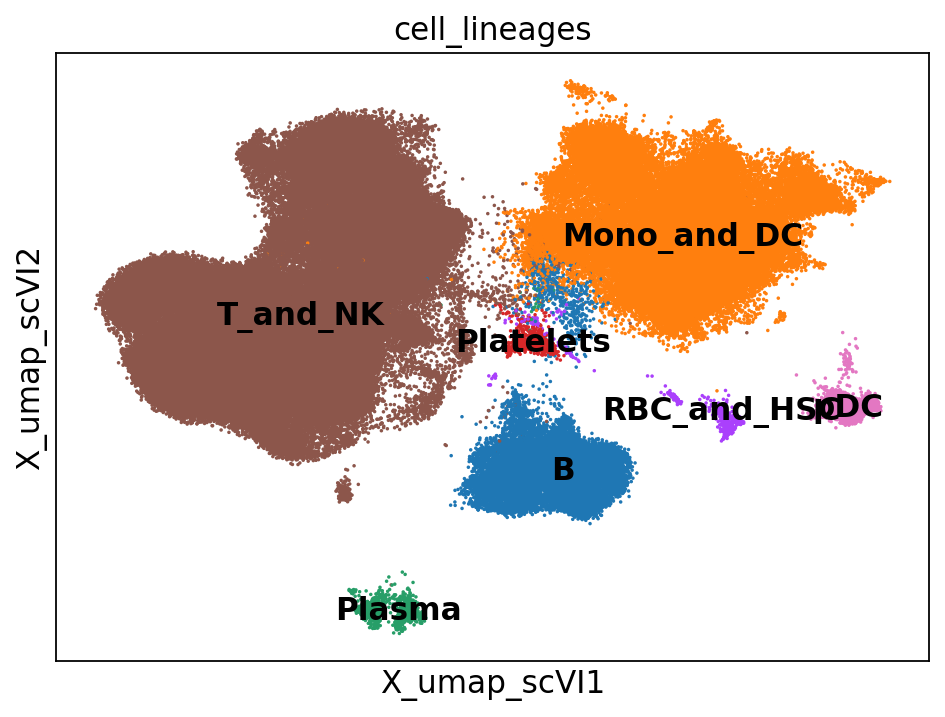

In [11]:
# Subsetting and randomizing for optimal plotting
random_indices = balanced_sample(adata.obs, cols = "cell_lineages", frac = fraction, shuffle = True, random_state = 42).cellID

sc.set_figure_params(figsize=(7, 5))
fig = sc.pl.embedding(adata[random_indices, :], basis="X_umap_scVI", color="cell_lineages", 
                      use_raw=False, show=True, return_fig=True, size=10, legend_loc="on data")
overwriteFigures=True
if overwriteFigures:
    plt.savefig(here('01_fromDatasets_to_CellLineages/figures/UMAP_clusters_res{}_annotated.pdf'.format(resolution_of_choice)), 
                bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

## Export cluster annotation

In [12]:
clusterAnnotDF = pd.DataFrame(adata.obs["cell_lineages"])
# Save annotation as DF
clusterAnnotDF.to_pickle(path=here('01_fromDatasets_to_CellLineages/results/INFLAMMATION_cluster_res{}_annotated.pkl'.format(resolution_of_choice)))

In [13]:
session_info.show()